In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 9)

In [2]:
import pqr

## Считываем данные

In [3]:
prices = pd.read_excel('factors/italy/price.xlsx', index_col=0, parse_dates=True)
index = pd.read_excel('factors/italy/benchmark.xlsx', index_col=0, parse_dates=True)['CLOSE']

pe = pd.read_excel('factors/italy/mults/pe.xlsx', index_col=0, parse_dates=True)
mcap = pd.read_excel('factors/italy/financials/market_cap.xlsx', index_col=0, parse_dates=True)
volume = pd.read_excel('factors/italy/liquidity/volume.xlsx', index_col=0, parse_dates=True)


for df in (prices, index, pe, mcap, volume):
    df.replace(0, np.nan, inplace=True)

## Создаем на основе данных факторы

In [4]:
universe = pqr.Universe(prices)
universe.filter(volume >= 2_000_000)

factorizer = pqr.Factorizer(
    pqr.Filter(universe),
    pqr.agg.Mean(3),
    pqr.Hold(3),
)

value = factorizer(pe, better="less")
size = factorizer(mcap, better="less")

benchmark = pqr.Benchmark.from_index(index, name="FTSE MIB")

## "Обучаем" факторную модель.

In [5]:
builder = pqr.PortfolioBuilder(
    pqr.WeightsByFactor(size),
    pqr.CashAllocation(prices, capital=100_000, fee=0.0005)
)

fm = pqr.fm.FactorModel(
    picking_strategies=[
        pqr.fm.Quantiles(0, 1/3),
        pqr.fm.Quantiles(1/3, 2/3),
        pqr.fm.Quantiles(2/3, 1),
    ],
    portfolio_builder=builder,
    add_wml=True
)

portfolios = fm(value, universe)

## После обучения у факторной модели появились портфели. С ними можно работать по отдельности

In [6]:
portfolios[0].returns

Winners
2016-05-31   -0.041580
2016-06-30   -0.183915
2016-07-31    0.110575
2016-08-31   -0.012717
2016-09-30   -0.059013
2016-10-31    0.126572
2016-11-30    0.001402
2016-12-31    0.185577
2017-01-31    0.025785
2017-02-28   -0.063579
2017-03-31    0.092768
2017-04-30    0.001131
2017-05-31   -0.018408
2017-06-30   -0.000738
2017-07-31    0.057373
2017-08-31   -0.040617
2017-09-30    0.023088
2017-10-31   -0.027159
2017-11-30   -0.024814
2017-12-31   -0.008892
2018-01-31    0.090476
2018-02-28   -0.024198
2018-03-31   -0.029896
2018-04-30    0.075225
2018-05-31   -0.183536
2018-06-30   -0.003842
2018-07-31    0.063155
2018-08-31   -0.174310
2018-09-30    0.037864
2018-10-31   -0.114210
2018-11-30    0.033877
2018-12-31   -0.080458
2019-01-31    0.030264
2019-02-28    0.119811
2019-03-31   -0.007916
2019-04-30    0.074259
2019-05-31   -0.183466
2019-06-30    0.046107
2019-07-31    0.016818
2019-08-31   -0.014764
2019-09-30    0.082610
2019-10-31    0.040742
2019-11-30    0.044567
201

In [7]:
pqr.metrics.Alpha(benchmark, statistics=True)(portfolios[0])

Alpha(value=-0.08703263285594924, t_stat=-1.4479361503332377, p_value=0.15301921096769766)

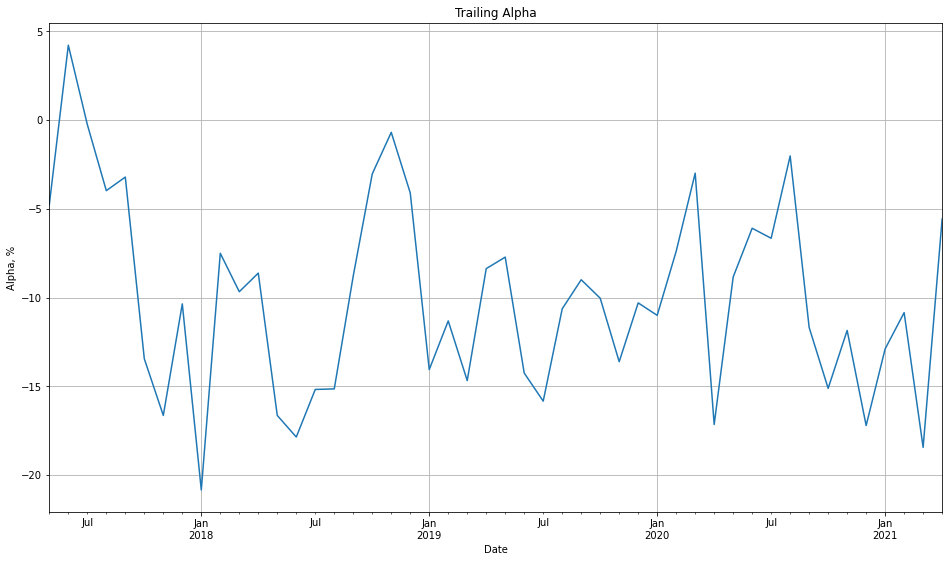

In [8]:
(pqr.metrics.TrailingAlpha(benchmark)(portfolios[0]) * 100).plot()

plt.title("Trailing Alpha")
plt.xlabel("Date")
plt.ylabel("Alpha, %")
plt.grid();

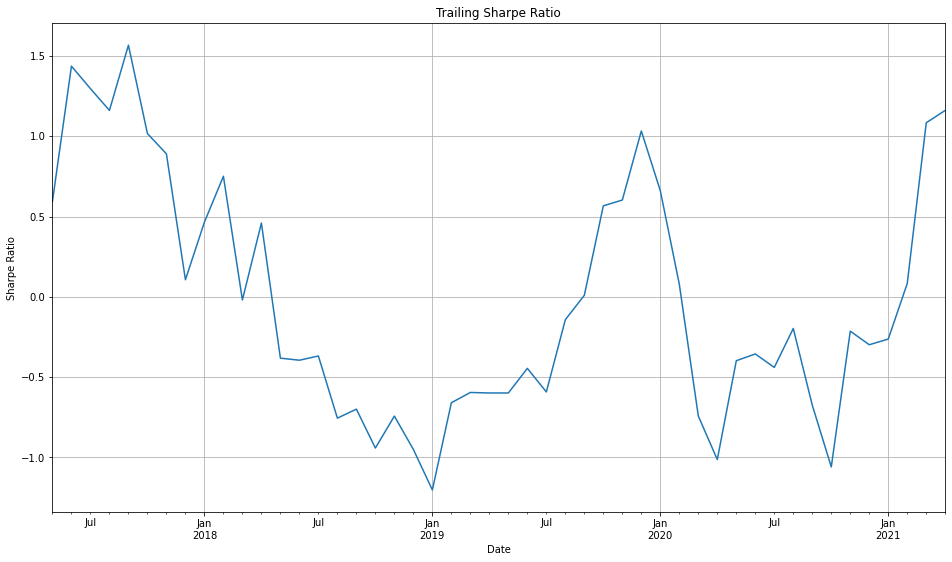

In [9]:
pqr.metrics.TrailingSharpeRatio()(portfolios[0]).plot()

plt.title("Trailing Sharpe Ratio")
plt.xlabel("Date")
plt.ylabel("Sharpe Ratio")
plt.grid();

In [10]:
pqr.metrics.MaxDrawdown()(portfolios[0])

-0.570136619601302

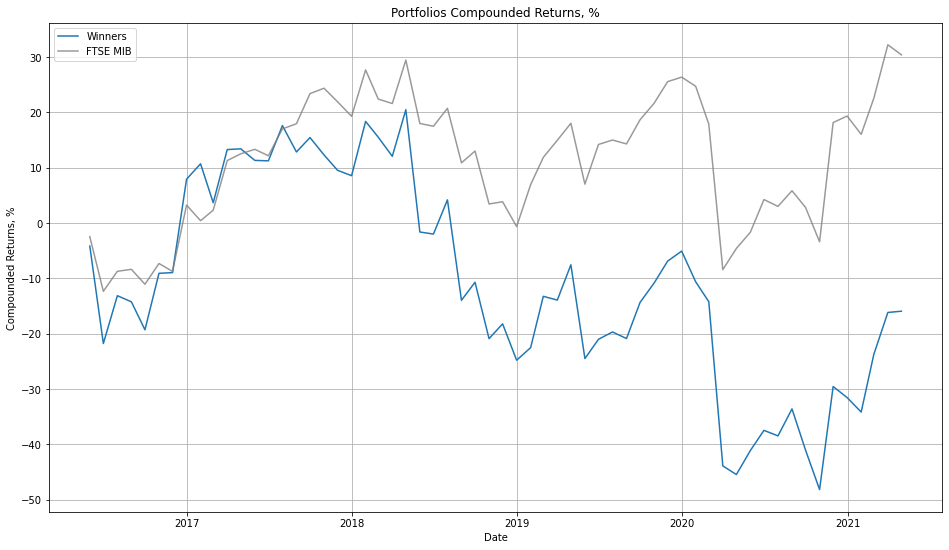

In [11]:
pqr.dash.Graph(
    pqr.metrics.CompoundedReturns(),
    benchmark,
    log_scale=False
)([portfolios[0]])

## Сравниваем портфели 

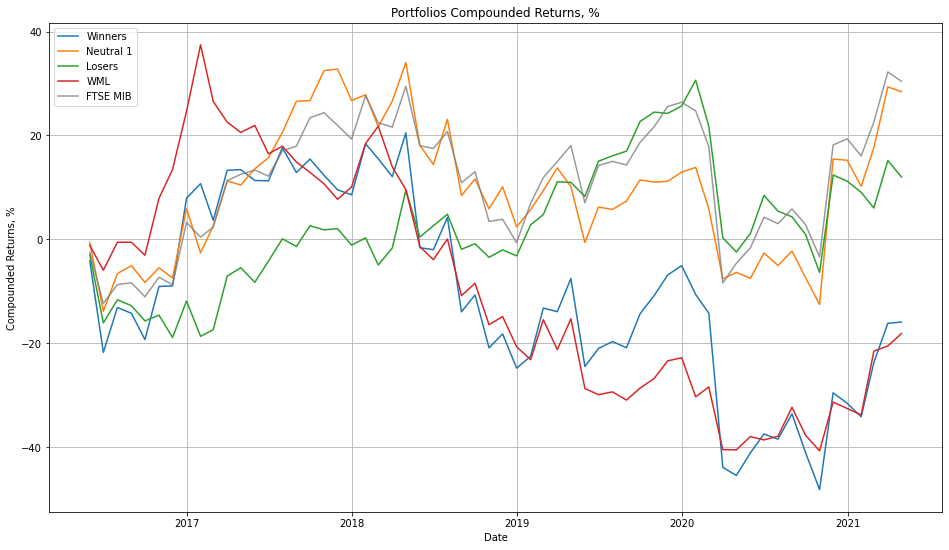

,Winners,Neutral 1,Losers,WML
"Total Return, %",-15.94,28.43,12.02,-18.15
"CAGR, %",-3.41,5.13,2.30,-3.93
"Mean Return, %",3.08 (0.19),7.85 (0.71),4.36 (0.47),-1.25 (-0.12)
"Volatility, %",35.85,24.54,20.64,23.63
"Win Rate, %",50.00,56.67,51.67,48.33
"Mean Turnover, %",218.74,429.32,347.52,583.46
"Maximum Drawdown, %",-57.01,-34.74,-28.34,-56.89
"Value at Risk, %",-63.56,-41.10,-26.85,-34.90
"Expected Tail Loss, %",-82.41,-43.89,-45.57,-50.37
"Expected Tail Reward, %",81.29,65.12,50.68,52.78


In [12]:
summary = pqr.dash.SummaryDashboard(benchmark)
summary(portfolios)

## grid_search

In [13]:
def factorizer_mean_factory(looking, lag, holding):
    return pqr.Factorizer(
        pqr.Filter(universe),
        pqr.agg.Mean(looking),
        pqr.Lag(lag),
        pqr.Hold(holding)
    )


param_grid = {
    "(1, 0, 1)": factorizer_mean_factory(1, 0, 1),
    "(1, 1, 1)": factorizer_mean_factory(1, 1, 1),
    "(3, 0, 3)": factorizer_mean_factory(3, 0, 3),
    "(3, 1, 3)": factorizer_mean_factory(3, 1, 3),
    "(6, 0, 6)": factorizer_mean_factory(6, 0, 6),
    "(6, 1, 6)": factorizer_mean_factory(6, 1, 6),
    "(9, 0, 9)": factorizer_mean_factory(9, 0, 9),
    "(9, 1, 9)": factorizer_mean_factory(9, 1, 9),
    "(12, 0, 12)": factorizer_mean_factory(12, 0, 12),
    "(12, 1, 12)": factorizer_mean_factory(12, 1, 12),
}

gs = pqr.fm.GridSearch(
    factorizers=param_grid,
    factor_model=fm
)

value_raw = pqr.Factor(pe, better="less")

results = gs(
    factor=value_raw,
    universe=universe,
    target=pqr.metrics.Alpha(benchmark)
)

In [14]:
results

,Winners,Neutral 1,Losers,WML
"(1, 0, 1)",-0.091446,-0.065412,0.004979,-0.100299
"(1, 1, 1)",-0.071009,-0.035531,0.007177,-0.079831
"(3, 0, 3)",-0.087033,0.001272,-0.019959,-0.066510
"(3, 1, 3)",-0.083600,0.004812,-0.010830,-0.072254
"(6, 0, 6)",-0.080211,-0.012059,0.041632,-0.121144
"(6, 1, 6)",-0.078522,-0.053131,0.056186,-0.133961
"(9, 0, 9)",-0.079248,0.024104,0.046373,-0.125135
"(9, 1, 9)",-0.081229,0.015009,0.041301,-0.122279
"(12, 0, 12)",-0.052318,-0.059335,0.069558,-0.123241
"(12, 1, 12)",-0.048788,-0.049971,0.058600,-0.107211


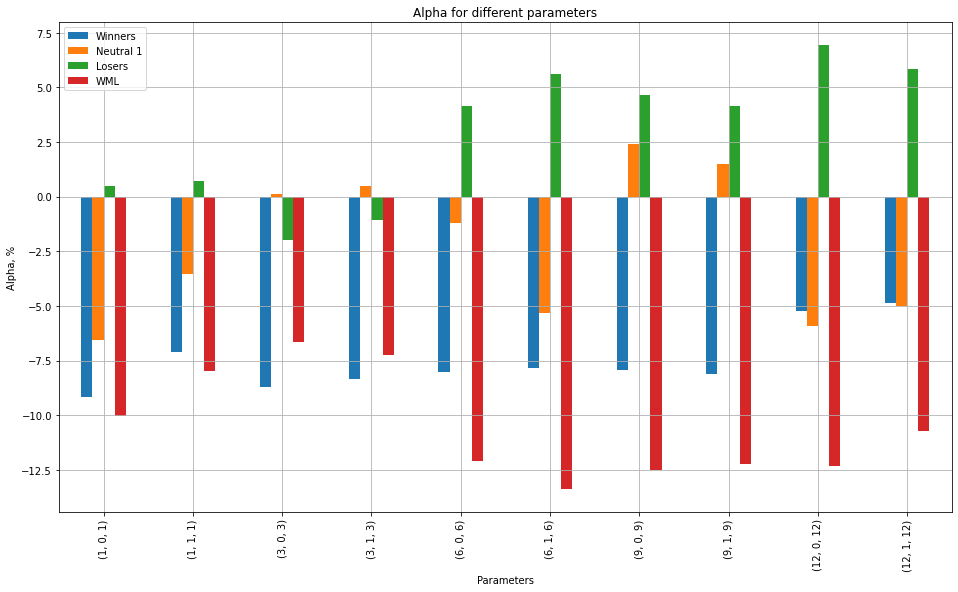

In [15]:
(results * 100).plot.bar()
plt.title("Alpha for different parameters")
plt.xlabel("Parameters")
plt.ylabel("Alpha, %")
plt.grid();

# zero_intelligence_test

In [16]:
best_portfolio = portfolios[2]

In [17]:
%%time
%%capture

zi = pqr.tests.ZeroIntelligenceTest(
    universe,
    builder,
    pqr.metrics.TrailingMeanReturn(),
    n=1000
)

zi_est = zi(best_portfolio)

CPU times: user 12.3 s, sys: 55 ms, total: 12.4 s
Wall time: 12.4 s


In [18]:
zi_est

Losers
2017-05-31    0.070
2017-06-30    0.214
2017-07-31    0.234
2017-08-31    0.228
2017-09-30    0.220
2017-10-31    0.356
2017-11-30    0.435
2017-12-31    0.772
2018-01-31    0.675
2018-02-28    0.569
2018-03-31    0.560
2018-04-30    0.596
2018-05-31    0.903
2018-06-30    0.860
2018-07-31    0.739
2018-08-31    0.924
2018-09-30    0.863
2018-10-31    0.905
2018-11-30    0.805
2018-12-31    0.827
2019-01-31    0.951
2019-02-28    0.892
2019-03-31    0.921
2019-04-30    0.787
2019-05-31    0.817
2019-06-30    0.778
2019-07-31    0.849
2019-08-31    0.784
2019-09-30    0.809
2019-10-31    0.703
2019-11-30    0.742
2019-12-31    0.685
2020-01-31    0.797
2020-02-29    0.897
2020-03-31    0.873
2020-04-30    0.876
2020-05-31    0.725
2020-06-30    0.735
2020-07-31    0.702
2020-08-31    0.590
2020-09-30    0.700
2020-10-31    0.734
2020-11-30    0.585
2020-12-31    0.604
2021-01-31    0.443
2021-02-28    0.218
2021-03-31    0.101
2021-04-30    0.113
dtype: float64

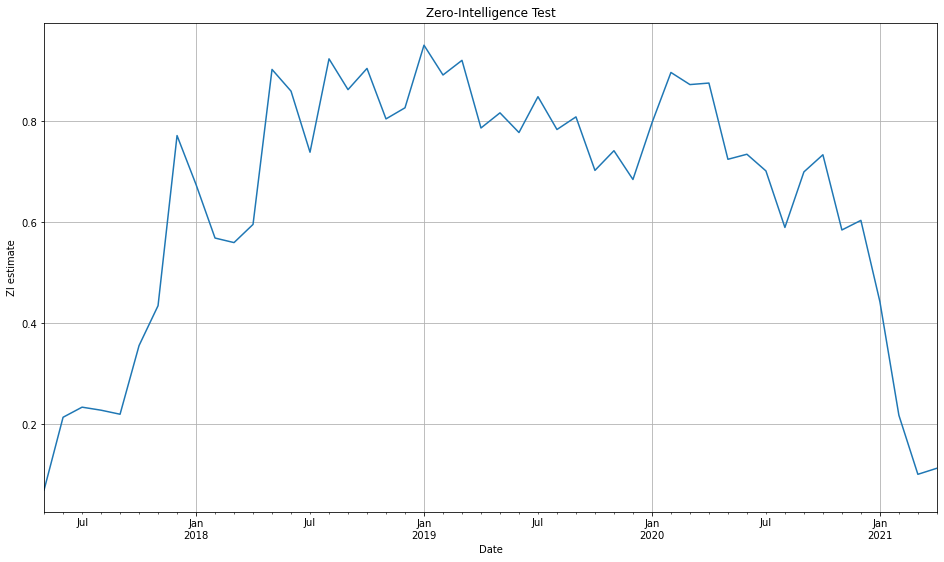

In [19]:
zi_est.plot()

plt.title("Zero-Intelligence Test")
plt.xlabel("Date")
plt.ylabel("ZI estimate")
plt.grid();